In [1]:
# Data Processing and Scoring: Code-Switching Analysis

## Setup and Data Loading

from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set working directory to project root
if ".env" not in os.listdir():
    os.chdir("/Users/jase/codeswitch-benchmark")

# Load environment variables
load_dotenv()

# Verify API key availability
print("API Keys Status:")
print(f"  Gemini: {bool(os.getenv('GEMINI_API_KEY'))}")
print(f"  Cohere: {bool(os.getenv('COHERE_API_KEY'))}")
print(f"  Mistral: {bool(os.getenv('MISTRAL_API_KEY'))}")

# Load Gemini response data
try:
    df = pd.read_csv("../data/raw/gemini_responses.csv")
    print(f"Loaded Gemini data: {len(df)} examples")
    df.head()
except FileNotFoundError:
    print("No Gemini response data found. Please run data collection first.")


API Keys Status:
  Gemini: True
  Cohere: True
  Mistral: True
Loaded Gemini data: 12 examples


In [2]:
## Calculate Response Metrics

# Calculate response length metrics
df["input_len"] = df["input_text"].apply(lambda x: len(str(x).split()))
df["output_len"] = df["output_text"].apply(lambda x: len(str(x).split()))
df["length_ratio"] = df["output_len"] / df["input_len"]

# Calculate token overlap (proportion of input words preserved in output)
def token_overlap(input_text, output_text):
    """Calculate the proportion of input words that appear in the output."""
    input_words = set(str(input_text).lower().split())
    output_words = set(str(output_text).lower().split())
    
    if not input_words:
        return np.nan
    
    overlap = len(input_words & output_words) / len(input_words)
    return overlap

df["token_overlap"] = df.apply(lambda r: token_overlap(r["input_text"], r["output_text"]), axis=1)

# Preview calculated metrics
print("Response metrics calculated:")
print(df[["id", "variety", "length_ratio", "token_overlap"]].head())


Response metrics calculated:
        id    variety  length_ratio  token_overlap
0  aave_01       AAVE     17.000000       1.000000
1  aave_02       AAVE     21.333333       1.000000
2  aave_03       AAVE     22.000000       0.833333
3  span_01  Spanglish     18.250000       1.000000
4  span_02  Spanglish     16.125000       0.875000


In [3]:
## Summary Statistics

print("Summary statistics for response metrics:")
print(df[["length_ratio", "token_overlap"]].describe().round(2))


Summary statistics for response metrics:
       length_ratio  token_overlap
count         12.00          12.00
mean          19.88           0.87
std            3.31           0.13
min           15.89           0.67
25%           17.00           0.77
50%           19.62           0.88
75%           22.16           1.00
max           26.00           1.00


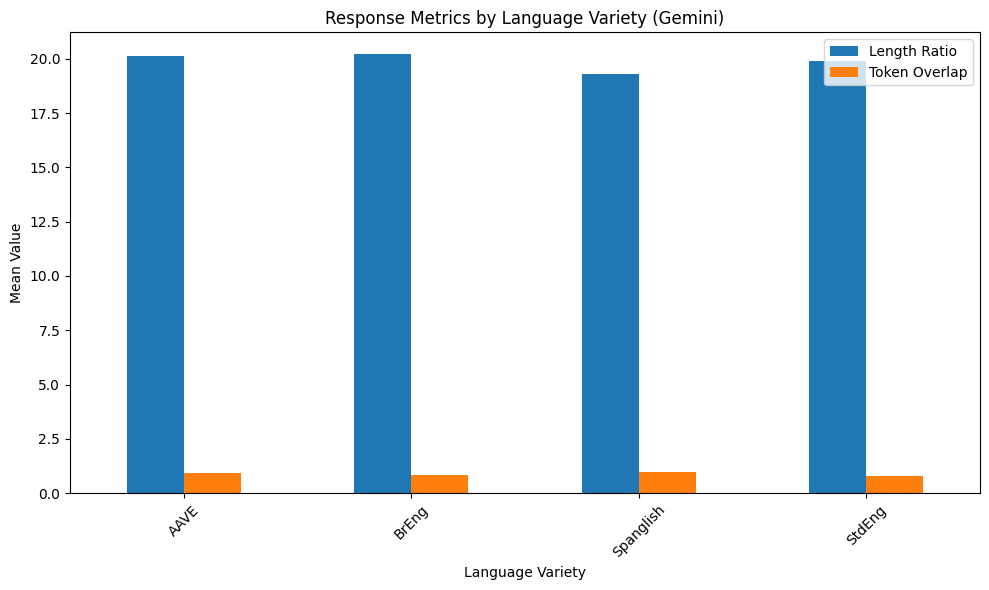

In [4]:
## Visualize Metrics by Language Variety

# Create bar plot comparing metrics across varieties
metrics_by_variety = df.groupby("variety")[["length_ratio", "token_overlap"]].mean()

metrics_by_variety.plot(kind="bar", figsize=(10, 6))
plt.title("Response Metrics by Language Variety (Gemini)")
plt.ylabel("Mean Value")
plt.xlabel("Language Variety")
plt.xticks(rotation=45)
plt.legend(["Length Ratio", "Token Overlap"])
plt.tight_layout()
plt.show()

In [5]:
## Save Processed Data

# Ensure processed data directory exists
os.makedirs("../data/processed", exist_ok=True)

# Save scored data
df.to_csv("../data/processed/gemini_scored.csv", index=False)
print(f"Saved processed data: {len(df)} examples with metrics")

Saved processed data: 12 examples with metrics


In [6]:
## Multi-Model Data Integration

# Check for additional model outputs and combine them
model_files = {
    'gemini': '../data/raw/gemini_responses.csv',
    'cohere': '../data/raw/cohere_smoke.csv',
    'mistral': '../data/raw/mistral_smoke.csv'
}

all_model_data = {}

for model_name, file_path in model_files.items():
    if os.path.exists(file_path):
        print(f"Found {model_name} data: {file_path}")
        model_df = pd.read_csv(file_path)
        model_df['model'] = model_name
        
        # Apply same metrics to all models
        model_df["input_len"] = model_df["input_text"].apply(lambda x: len(str(x).split()))
        model_df["output_len"] = model_df["output_text"].apply(lambda x: len(str(x).split()))
        model_df["length_ratio"] = model_df["output_len"] / model_df["input_len"]
        model_df["token_overlap"] = model_df.apply(lambda r: token_overlap(r["input_text"], r["output_text"]), axis=1)
        
        all_model_data[model_name] = model_df
    else:
        print(f"No {model_name} data found: {file_path}")

# Combine all available model data
if len(all_model_data) > 1:
    combined_df = pd.concat(all_model_data.values(), ignore_index=True)
    print(f"Combined data from {len(all_model_data)} models: {len(combined_df)} examples")
    
    # Save combined dataset
    combined_df.to_csv("../data/processed/all_models_scored.csv", index=False)
    print("Saved combined model data")
else:
    combined_df = df  # Use Gemini data as default
    print("Using Gemini data only")

combined_df.head()


Found gemini data: ../data/raw/gemini_responses.csv
Found cohere data: ../data/raw/cohere_smoke.csv
Found mistral data: ../data/raw/mistral_smoke.csv
Combined data from 3 models: 16 examples
Saved combined model data


,id,variety,task,input_text,output_text,model,input_len,output_len,length_ratio,token_overlap
0,aave_01,AAVE,paraphrase,He finna go to the store. You sliding?,"Here are a few options, both paraphrasing and ...",gemini,8,136,17.000000,1.000000
1,aave_02,AAVE,explain,Ion think that plan gon' work.,Here are a few ways to paraphrase or continue ...,gemini,6,128,21.333333,1.000000
2,aave_03,AAVE,continue,We was tryna finish that yesterday,Here are a few ways to paraphrase or continue ...,gemini,6,132,22.000000,0.833333
3,span_01,Spanglish,paraphrase,"Vamos later, it's muy close to la tienda.",Here are a few ways to paraphrase or continue ...,gemini,8,146,18.250000,1.000000
4,span_02,Spanglish,explain,"No entiendo bien, pero I think it's fine.","Here are a few options, either paraphrasing or...",gemini,8,129,16.125000,0.875000
